# Prithvi WxC Downscaling: Model Inference

*Note to set up env run these commands in your terminal before running the notebook*
- `conda create -n prithviwxc python=3.11 xarray scipy h5netcdf`
- `conda activate prithviwxc`
- `pip install -e <path to cloned PrithviWxC repo>` (see https://github.com/NASA-IMPACT/Prithvi-WxC)
- `export PYTHONPATH=<path to weather-fm-ibm>`

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%%bash
echo $PYTHONPATH

/u/juliank/CODE/weather-fm-ibm/


In [35]:
import os
import random
from pathlib import Path

import matplotlib.pyplot as plt
from itertools import product
import numpy as np
import torch

from granitewxc.utils.distributed import init_ddp
from granitewxc.utils.config import get_config
from granitewxc.utils.data import get_dataloaders
from granitewxc.utils.downscaling_model import get_finetune_model

from examples.granitewxc_downscaling.utils.plot import *

In [4]:
torch.jit.enable_onednn_fusion(True)
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = True

random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
torch.manual_seed(42)
np.random.seed(42)

### Load Config

In [5]:
os.environ["LOCAL_RANK"] = "0"
os.environ["RANK"] = "0"
os.environ["WORLD_SIZE"] = "1"
os.environ["MASTER_ADDR"] = "localhost"
os.environ["MASTER_PORT"] = "1234"

local_rank, rank = init_ddp(use_gpu=True)

In [6]:
model_filename = 'granite.wxc.2300m.v1.downscaling.v1.pth'
weights_path = os.path.join('<your_path>', model_filename)

### Load Config

In [7]:
config_path = '../configs/inference_config.yaml'
config = get_config(config_path)

In [8]:
config.batch_size = 2

In [ ]:
# Only for CCC, remove in future
config.data.data_path_surface = '/dccstor/wfm/shared/datasets/training/merra-2_v1/merra-2'
config.data.data_path_vertical = '/dccstor/wfm/shared/datasets/training/merra-2_v1/merra-2'
config.data.climatology_path_surface = '/dccstor/wfm/shared/datasets/training/merra-2_v1/climatology'
config.data.climatology_path_vertical = '/dccstor/wfm/shared/datasets/training/merra-2_v1/climatology'

config.model.input_scalers_surface_path = '/dccstor/wfm/shared/datasets/training/merra-2_v1/climatology/musigma_surface.nc'
config.model.input_scalers_vertical_path = '/dccstor/wfm/shared/datasets/training/merra-2_v1/climatology/musigma_vertical.nc'
config.model.output_scalers_surface_path = '/dccstor/wfm/shared/datasets/training/merra-2_v1/climatology/anomaly_variance_surface.nc'
config.model.output_scalers_vertical_path = '/dccstor/wfm/shared/datasets/training/merra-2_v1/climatology/anomaly_variance_vertical.nc'

### Load Data

In [9]:
config.data.cache = False
config.data.val_time_range_start = '2020-01-01T00:00:00'
config.data.val_time_range_end = '2020-01-15T23:59:59'

_, valid_loader, _, _ = get_dataloaders(config)

--> Training batches: 7,561
--> Validation batches: 59
--> Training samples: 15,123
--> Validation samples: 119


In [10]:
for batch in valid_loader:
    for k, v in batch.items():
        print(f"{k}: {v.shape}")
    break
    

y: torch.Size([2, 1, 360, 576])
static_y: torch.Size([2, 11, 360, 576])
climate_y: torch.Size([2, 1, 360, 576])
x: torch.Size([2, 280, 60, 96])
static_x: torch.Size([2, 11, 60, 96])
climate_x: torch.Size([2, 140, 60, 96])


In [11]:
input_shape = batch['x'].shape
output_shape = batch['y'].shape

### Load Model

*Note: the following code assumes that gpu is available*

In [13]:
config.model.encoder_shift = False

model = get_finetune_model(config, logger=None)
model.load_state_dict(torch.load(weights_path, weights_only=True, map_location=f'cuda:{torch.cuda.current_device()}'))
model.to(torch.cuda.current_device())
model.eval() 

Creating the model.
Encoder shifting: False


ClimateDownscaleFinetuneModel(
  (backbone): PrithviWxCEncoderDecoder(
    (lgl_block): LocalGlobalLocalBlock(
      (transformers): ModuleList(
        (0-24): 25 x Transformer(
          (drop_path): DropPath()
          (attention): Sequential(
            (0): LayerNormPassThrough((2560,), eps=1e-05, elementwise_affine=True)
            (1): MultiheadAttention(
              (qkv_layer): Linear(in_features=2560, out_features=7680, bias=False)
              (w_layer): Linear(in_features=2560, out_features=2560, bias=False)
            )
          )
          (ff): Sequential(
            (0): LayerNorm((2560,), eps=1e-05, elementwise_affine=True)
            (1): Mlp(
              (net): Sequential(
                (0): Linear(in_features=2560, out_features=10240, bias=True)
                (1): GELU(approximate='none')
                (2): Dropout(p=0.0, inplace=False)
                (3): Linear(in_features=10240, out_features=2560, bias=True)
                (4): Dropout(p=0.0, 

### Generate Predictions

In [14]:
num_predictions = 2

In [15]:
inputs = np.empty((num_predictions, *input_shape[1:]))
targets = np.empty((num_predictions, *output_shape[1:]))
predictions = np.empty((num_predictions, *output_shape[1:]))
inputs.shape, targets.shape, predictions.shape

((2, 280, 60, 96), (2, 1, 360, 576), (2, 1, 360, 576))

In [16]:
with torch.no_grad():
    for i, batch in enumerate(valid_loader):
        
        batch = {k: v.to(torch.cuda.current_device()) for k, v in batch.items()}
        preds = model(batch) # output of model is regression_output, classification_output

        save_idx_start = i * config.batch_size 
        save_idx_end = min(save_idx_start + config.batch_size, num_predictions)
        if save_idx_start >= num_predictions:
            break
            
        inputs[save_idx_start: save_idx_end] = batch['x'][:save_idx_end - save_idx_start].cpu()
        targets[save_idx_start: save_idx_end] = batch['y'][:save_idx_end - save_idx_start].cpu()
        predictions[save_idx_start: save_idx_end] = preds[:save_idx_end - save_idx_start].cpu()

In [17]:
inputs.shape, targets.shape, predictions.shape

((2, 280, 60, 96), (2, 1, 360, 576), (2, 1, 360, 576))

### Plot Target and Predictions

In [18]:
input_vars = [*config.data.input_surface_vars, *product(config.data.input_vertical_vars, config.data.input_levels)]
coarsening_factor = targets.shape[-1] / inputs.shape[-1] 

In [39]:
var = 0 # target variable
var_name = "T2M"
input_var = input_vars.index(var_name)
var_name_title = '2M air temperature' # "Surface temperature"
var_unit = "K"

In [21]:
idx = 1 # 0 = first sample
sample_time = str(sorted(list(valid_loader.dataset.dataset.valid_timestamps))[idx])

In [22]:
plot_input = inputs[idx, input_var, :, :]
plot_target = targets[idx, var, : ,:]
plot_pred = predictions[idx, var, :, :]
plot_residual = plot_target - plot_pred

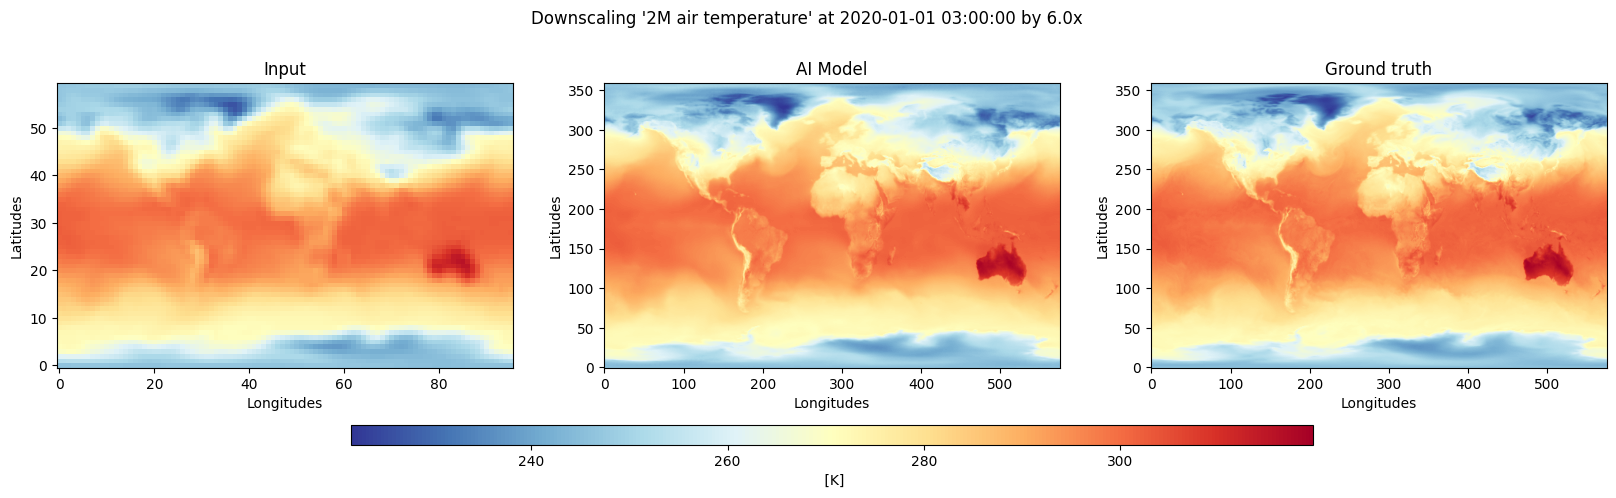

In [43]:
plot_val_kwargs = dict(
    cmap='RdYlBu_r',
    vmin = min(np.min(plot_input), np.min(plot_target), np.min(plot_pred)),
    vmax = max(np.max(plot_input), np.max(plot_target), np.max(plot_pred)),
    plot_residual_kwargs = dict(
        cmap = 'bwr',
        vmin = -np.max(np.abs(plot_residual)),
        vamx = np.max(np.abs(plot_residual)),
    ),
    var_name_title=var_name_title,
    var_unit=var_unit
)

plot_model_results(
    [plot_input, plot_pred, plot_target],
    ['Input', 'AI Model', 'Ground truth'],
    title=f"Downscaling '{var_name_title}' at {sample_time} by {coarsening_factor}x",
    **plot_val_kwargs
)

Text(0.5, 1.0, 'Power spectrum of 2M air temperature')

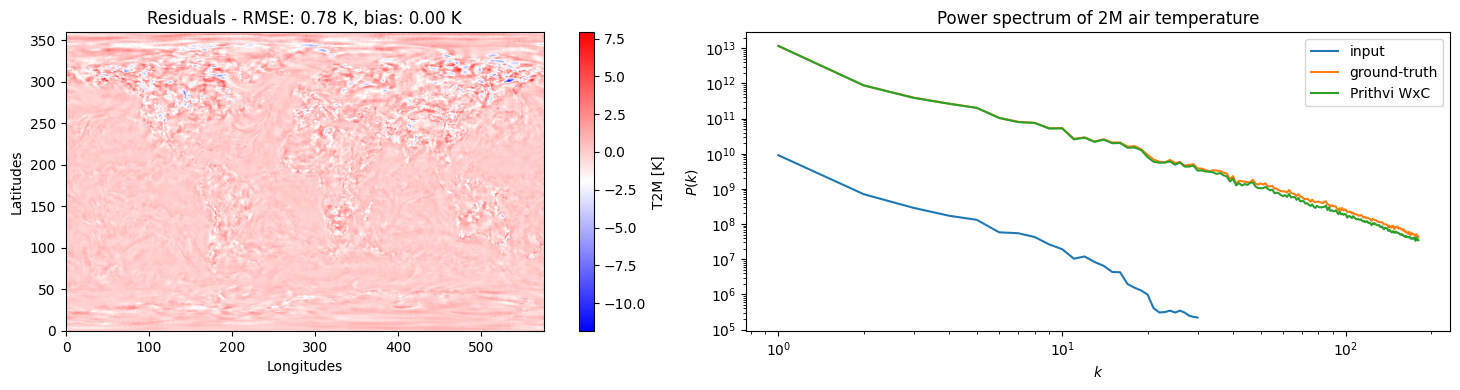

In [47]:
vmin_res = -np.max(np.abs(plot_residual))
vmax_res = np.max(np.abs(plot_residual))
pred_bias = spatial_bias(plot_pred, plot_target)
pred_rmse = spatial_rmse(plot_pred, plot_target)

fig, axs = plt.subplots(nrows=1,ncols=2,
                        figsize=(15,4))

title = 'Residuals - RMSE: {:.2f} K, bias: {:.2f} K'.format(pred_rmse, pred_bias)
im_res = plot_spatial(plot_residual, axs[0], title,  **plot_val_kwargs.get('plot_residual_kwargs'))
cbar = plt.colorbar(im_res, ax=axs[0], orientation='vertical', label=f'{var_name} [K]')

plot_power_spectrum(plot_input, axs[1])
plot_power_spectrum(plot_target, axs[1])
plot_power_spectrum(plot_pred, axs[1])
axs[1].legend(['input', 'ground-truth', 'Prithvi WxC'])
axs[1].set_title(f'Power spectrum of {var_name_title}')